# Artificial dataset plots

This notebook contains the code used to generate the plots in Section 3.3 (Artificial datasets).

**The assumption is that all three of the trials for each experiment have completed.**

**If you are only trying to reproduce the plots, run the cell below and skip [here](#Fitness-distributions).**

In [1]:
from pathlib import Path
import itertools as it

from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

com_dir = Path("../data/artificial/cao_over_matching_final_cost")
moc_dir = Path("../data/artificial/matching_over_cao_final_cost")
method_colours = {"com": "tab:green", "moc": "tab:orange"}
nseeds = 3


# Top percentile across all generations


In [2]:
def get_summary(directory, max_seed):

    dfs = []
    for seed in range(max_seed):
        try:
            df = pd.read_csv(f"{directory}/{seed}/summary/main.csv")
            df["seed"] = seed
            dfs.append(df)
        except FileNotFoundError as err:
            print(err)

    main = pd.concat(dfs, axis=0, ignore_index=True)
    main = main.drop_duplicates(
        subset=["nrows", "ncols", "memory", "fitness", "seed"], keep="last"
    )

    return main


In [3]:
com = get_summary(com_dir, nseeds)
com.shape


(35144, 7)

In [4]:
moc = get_summary(moc_dir, nseeds)
moc.shape


(36372, 7)

In [5]:
def get_best_percentiles(data, percentile):

    threshold = np.percentile(data["fitness"], percentile)
    return data[data["fitness"] < threshold]


In [6]:
com_percentile = get_best_percentiles(com, 1)
moc_percentile = get_best_percentiles(moc, 1)

com_percentile.shape, moc_percentile.shape


((352, 7), (364, 7))

In [7]:
for data, experiment in zip((com_percentile, moc_percentile), (com_dir, moc_dir)):
    for _, row in data.astype(int).iterrows():

        seed = row["seed"]
        gen = row["generation"]
        ind = row["individual"]

        df = pd.read_csv(experiment / f"{seed}/data/{gen}/{ind}/main.csv", dtype=object)

        top_percentile_dir = experiment / "top"
        top_percentile_dir.mkdir(exist_ok=True)

        df.to_csv(top_percentile_dir / f"{gen}/{ind}/main.csv", index=False)


FileNotFoundError: [Errno 2] File b'../data/artificial/cao_over_matching_final_cost/0/data/59/98/main.csv' does not exist: b'../data/artificial/cao_over_matching_final_cost/0/data/59/98/main.csv'

In [ ]:
com_percentile.to_csv(com_dir / "top/main.csv", index=False)
moc_percentile.to_csv(moc_dir / "top/main.csv", index=False)

# Fitness distributions

In [8]:
com_percentile = pd.read_csv(com_dir / "top/main.csv")
moc_percentile = pd.read_csv(moc_dir / "top/main.csv")

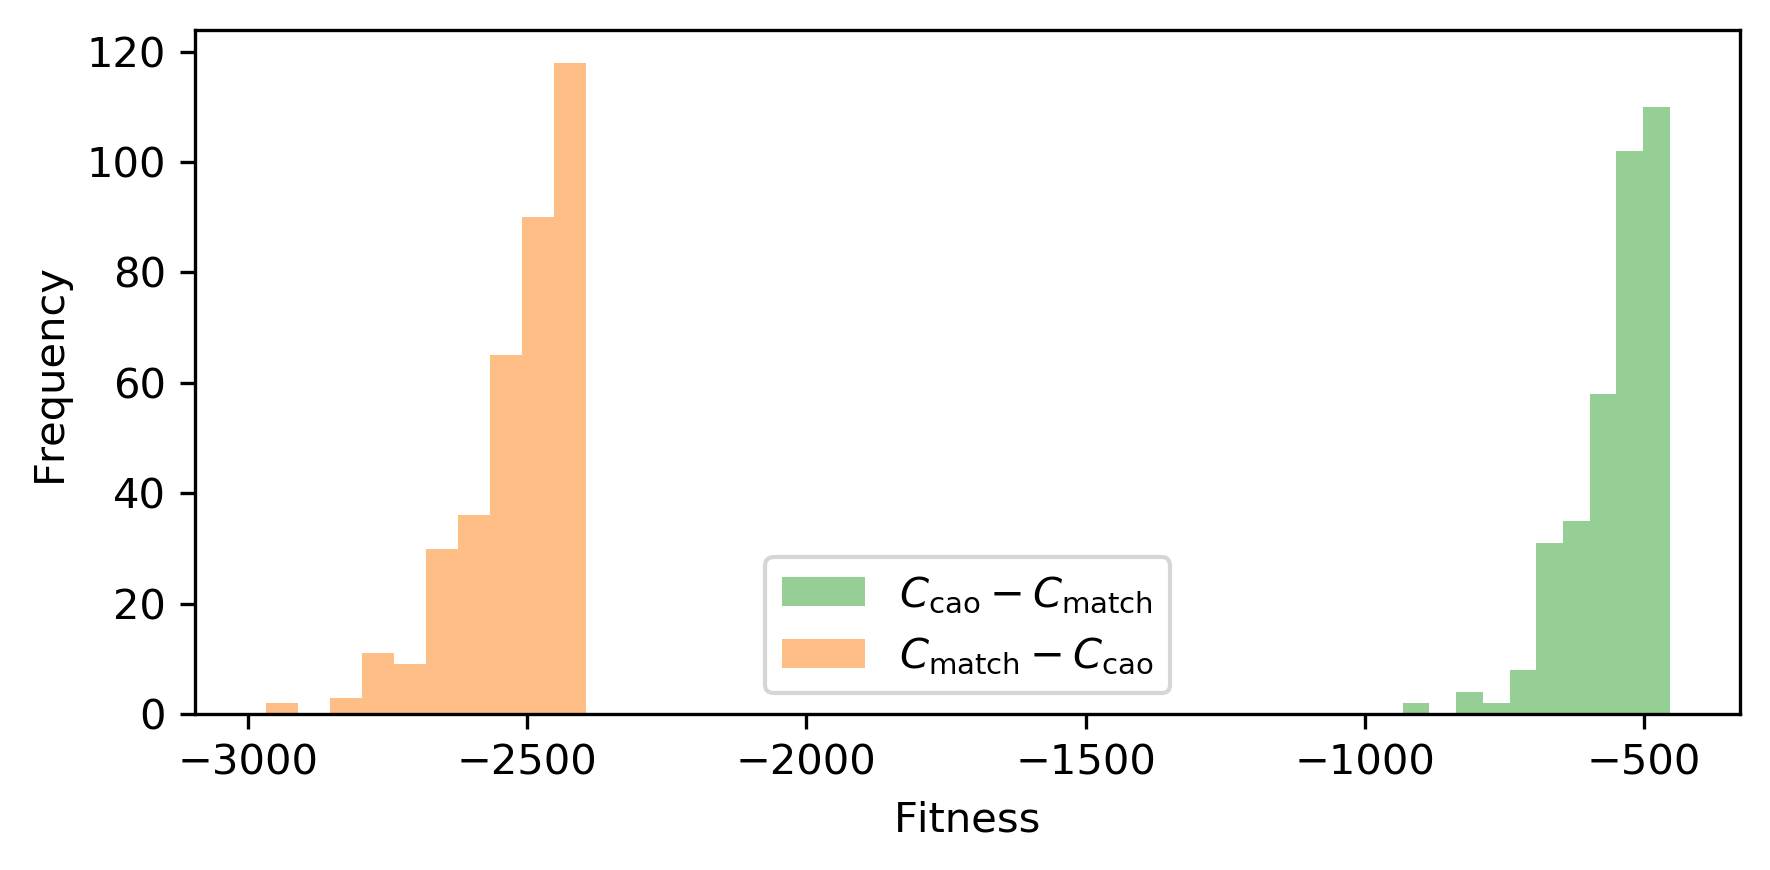

In [14]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

ax.hist(
    com_percentile["fitness"],
    color=method_colours["com"],
    alpha=0.5,
    label="$C_{\mathrm{cao}} - C_{\mathrm{match}}$",
)
ax.hist(
    moc_percentile["fitness"],
    color=method_colours["moc"],
    alpha=0.5,
    label="$C_{\mathrm{match}} - C_{\mathrm{cao}}$",
)

ax.set_xlabel("Fitness")
ax.set_ylabel("Frequency")

ax.legend()

plt.tight_layout()
plt.savefig("../img/Fig9.pdf", transparent=True)


# Univariate statistic distribution plots

Each dataset in the top percentile of each experiment is transformed via centred PCA to a single component. Univariate statistics are taken and stored to be distributed.

In [10]:
def get_stats(experiment):

    dfs = []
    top = pd.read_csv(experiment / "top/main.csv")
    for _, row in top.astype(int).iterrows():

        seed = row["seed"]
        gen = row["generation"]
        ind = row["individual"]

        df = pd.read_csv(
            experiment / f"top/{seed}/{gen}/{ind}/main.csv", dtype=object
        )

        pca = PCA(n_components=1)
        data = pca.fit_transform(df)
        dfs.append(pd.DataFrame(data))

    variances, skews, kurtoses = [], [], []
    lower_deciles, upper_deciles, iqrs = [], [], []
    for df in dfs:
        variances += df.var().tolist()
        skews += stats.skew(df).tolist()
        kurtoses += stats.kurtosis(df).tolist()

        lower_deciles.append(np.percentile(df, 10))
        upper_deciles.append(np.percentile(df, 90))
        iqrs.append(stats.iqr(df))

    return {
        "variance": variances,
        "skewness": skews,
        "kurtosis": kurtoses,
        "lower decile": lower_deciles,
        "upper decile": upper_deciles,
        "interquartile range": iqrs,
    }


In [11]:
com_stats = get_stats(com_dir)
moc_stats = get_stats(moc_dir)


In [12]:
def hist_with_dist_plot(statistic, bins=10, steps=100, filename=None):

    fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

    for values, colour, label in zip(
        [com_stats[statistic], moc_stats[statistic]],
        list(method_colours.values()),
        [r"$C_{\mathrm{cao}} - C_{\mathrm{match}}$", "$C_{\mathrm{match}} - C_{\mathrm{cao}}$"],
    ):
        xs = np.linspace(min(values), max(values), steps)
        kernel = stats.gaussian_kde(values)

        ax.hist(values, bins, color=colour, alpha=0.5, label=label, density=True)
        ax.plot(xs, kernel(xs), color=colour)

    ax.set_xlabel(statistic.capitalize())
    ax.set_ylabel("Density")

    ax.legend()
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, transparent=True)


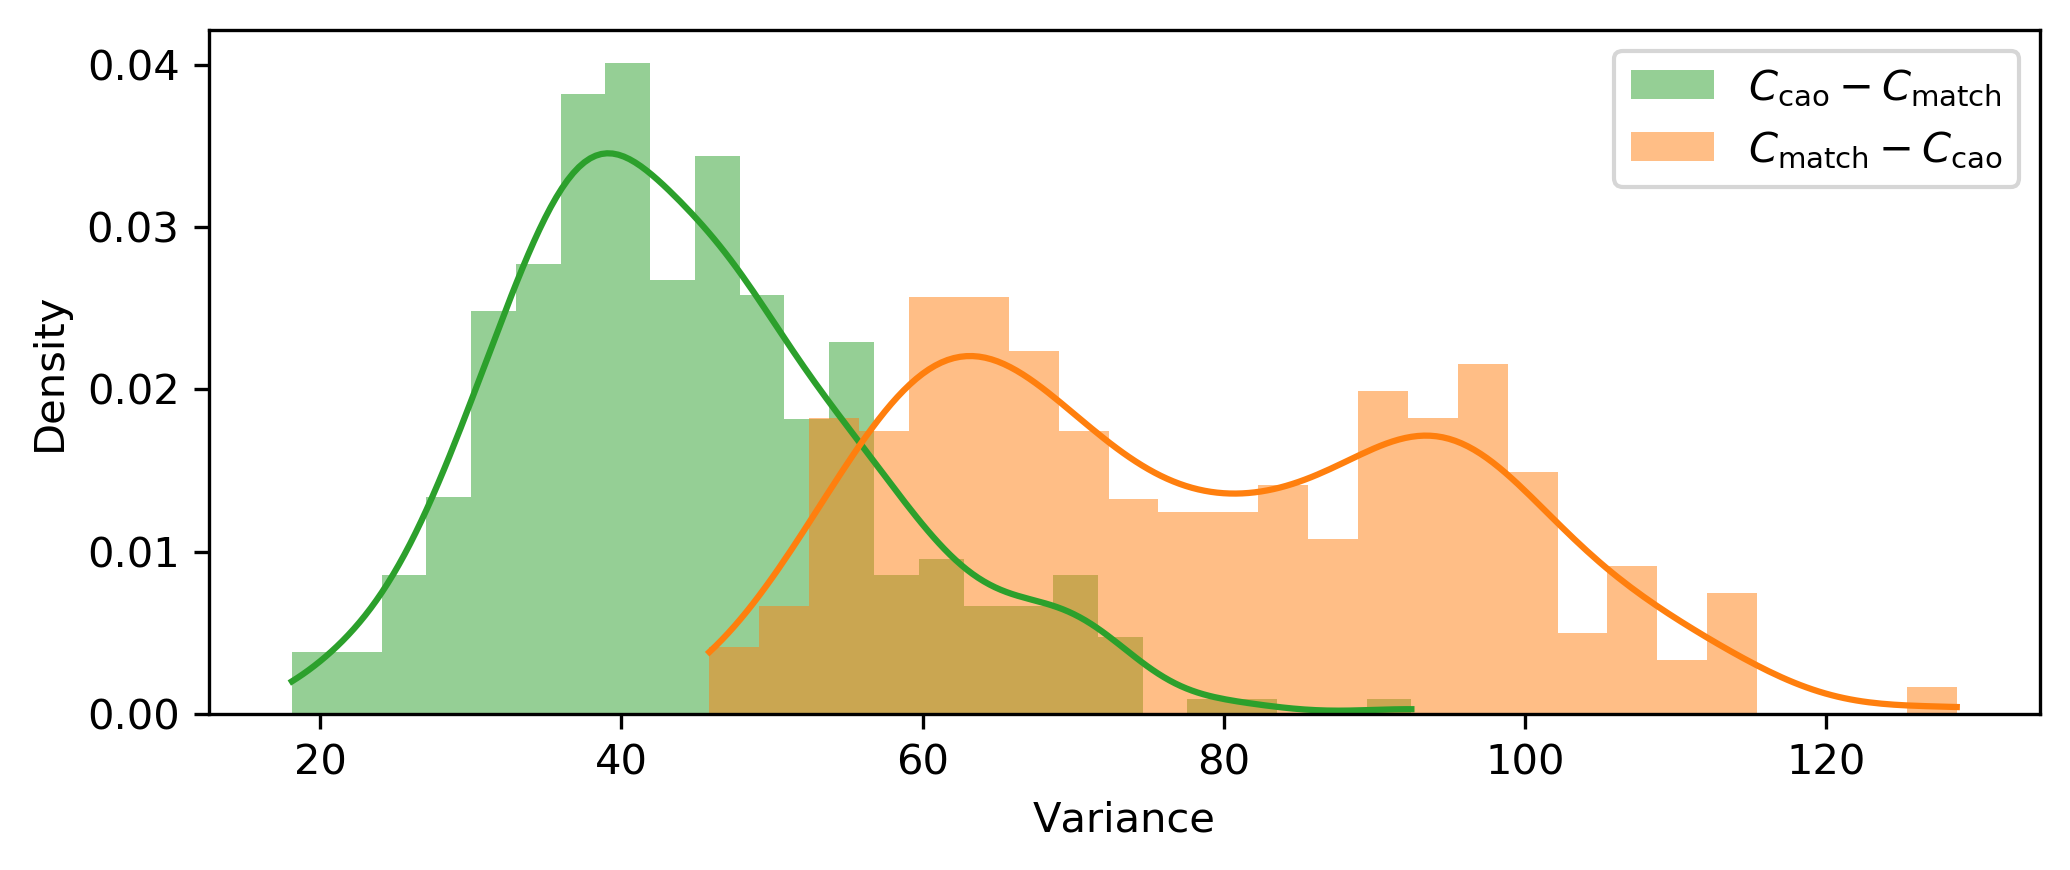

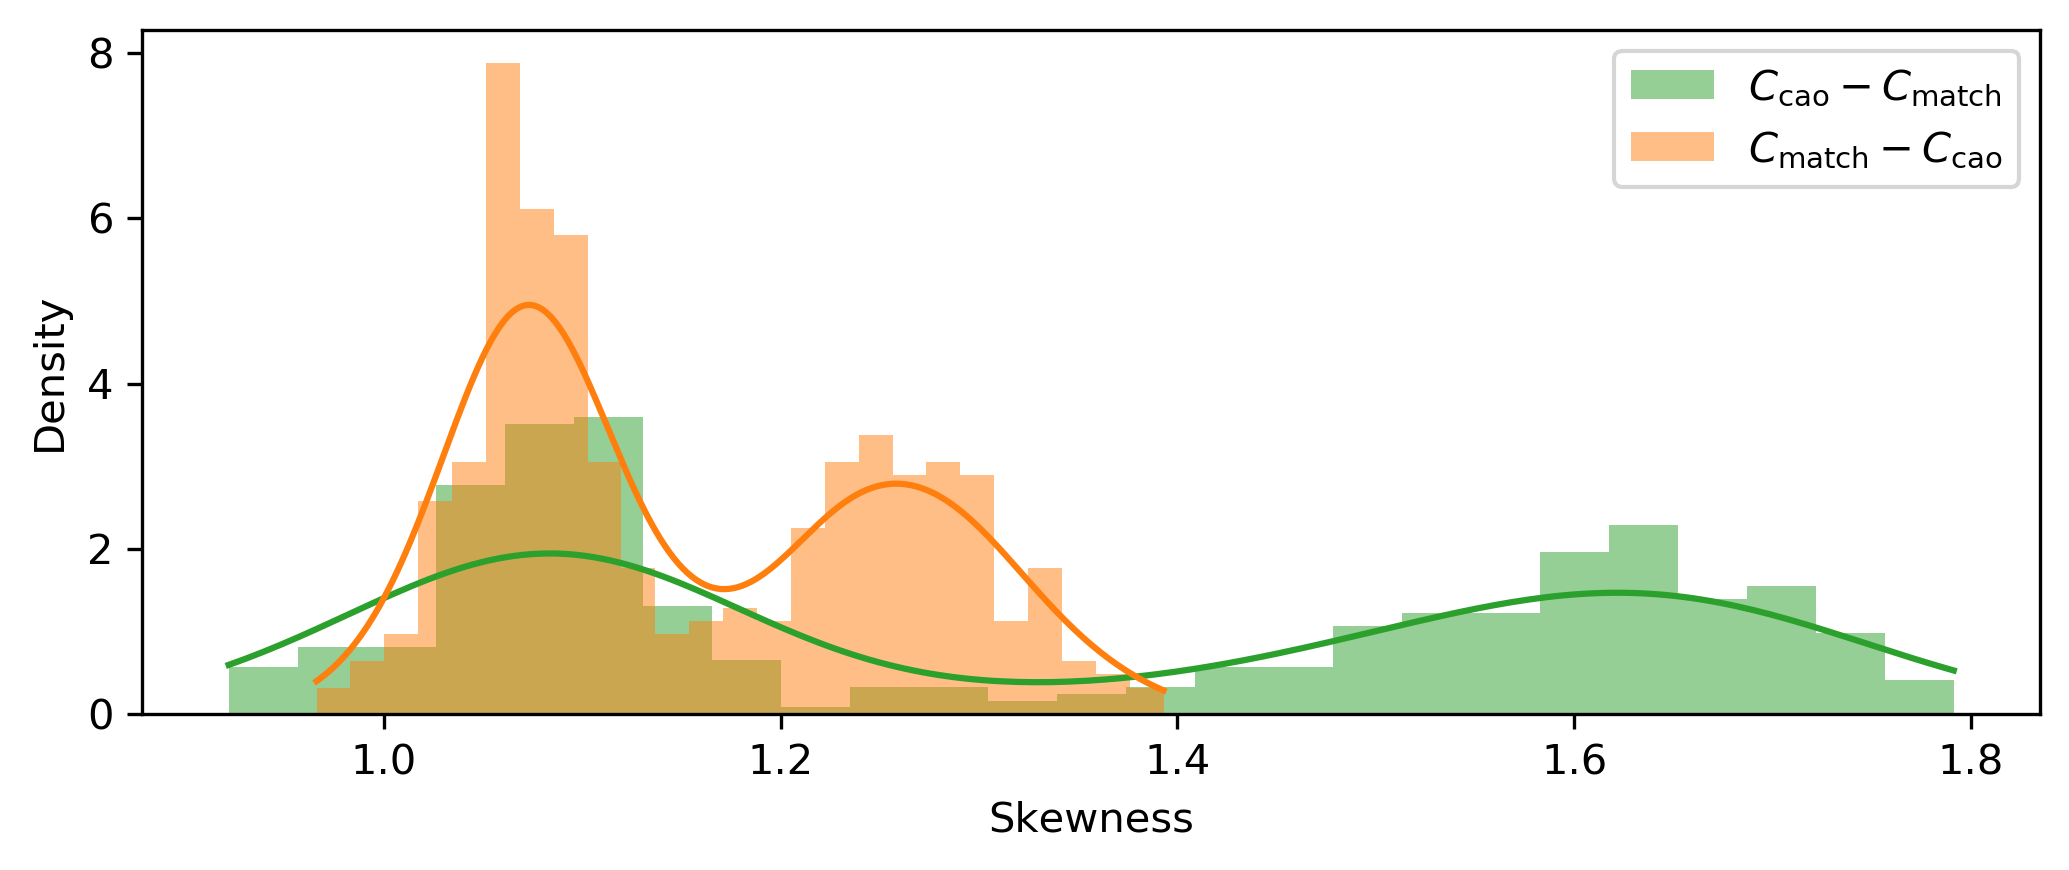

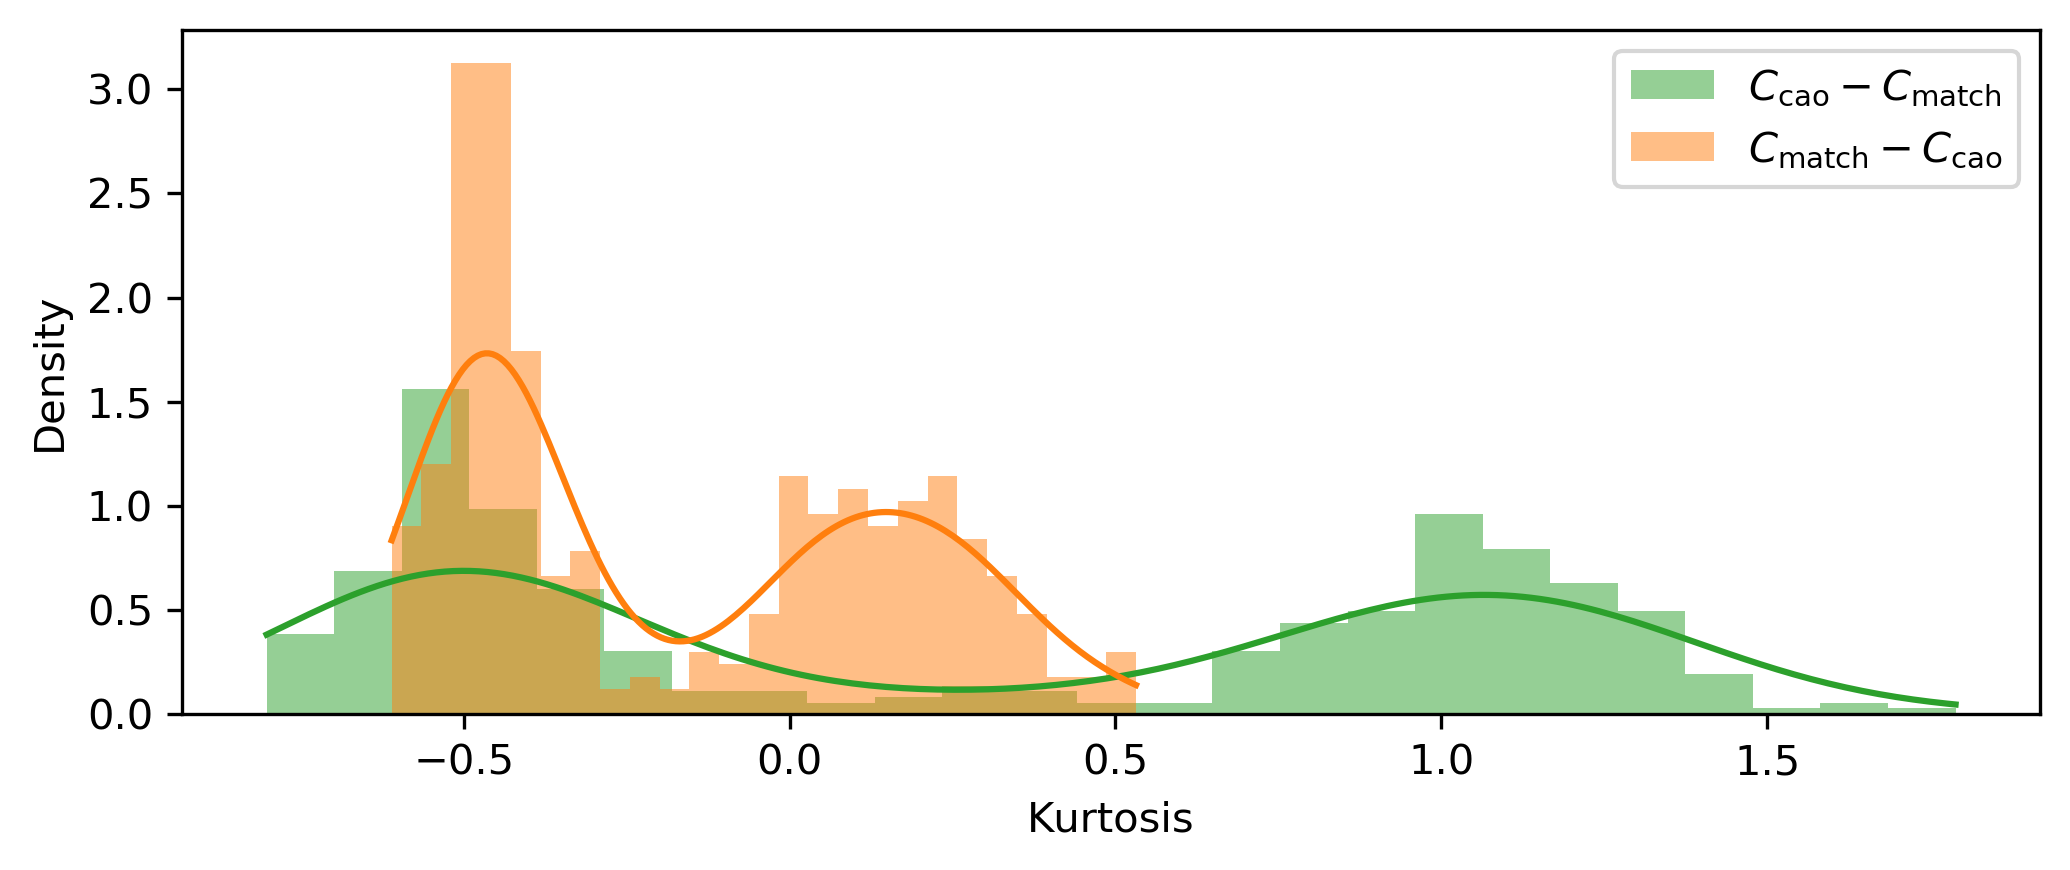

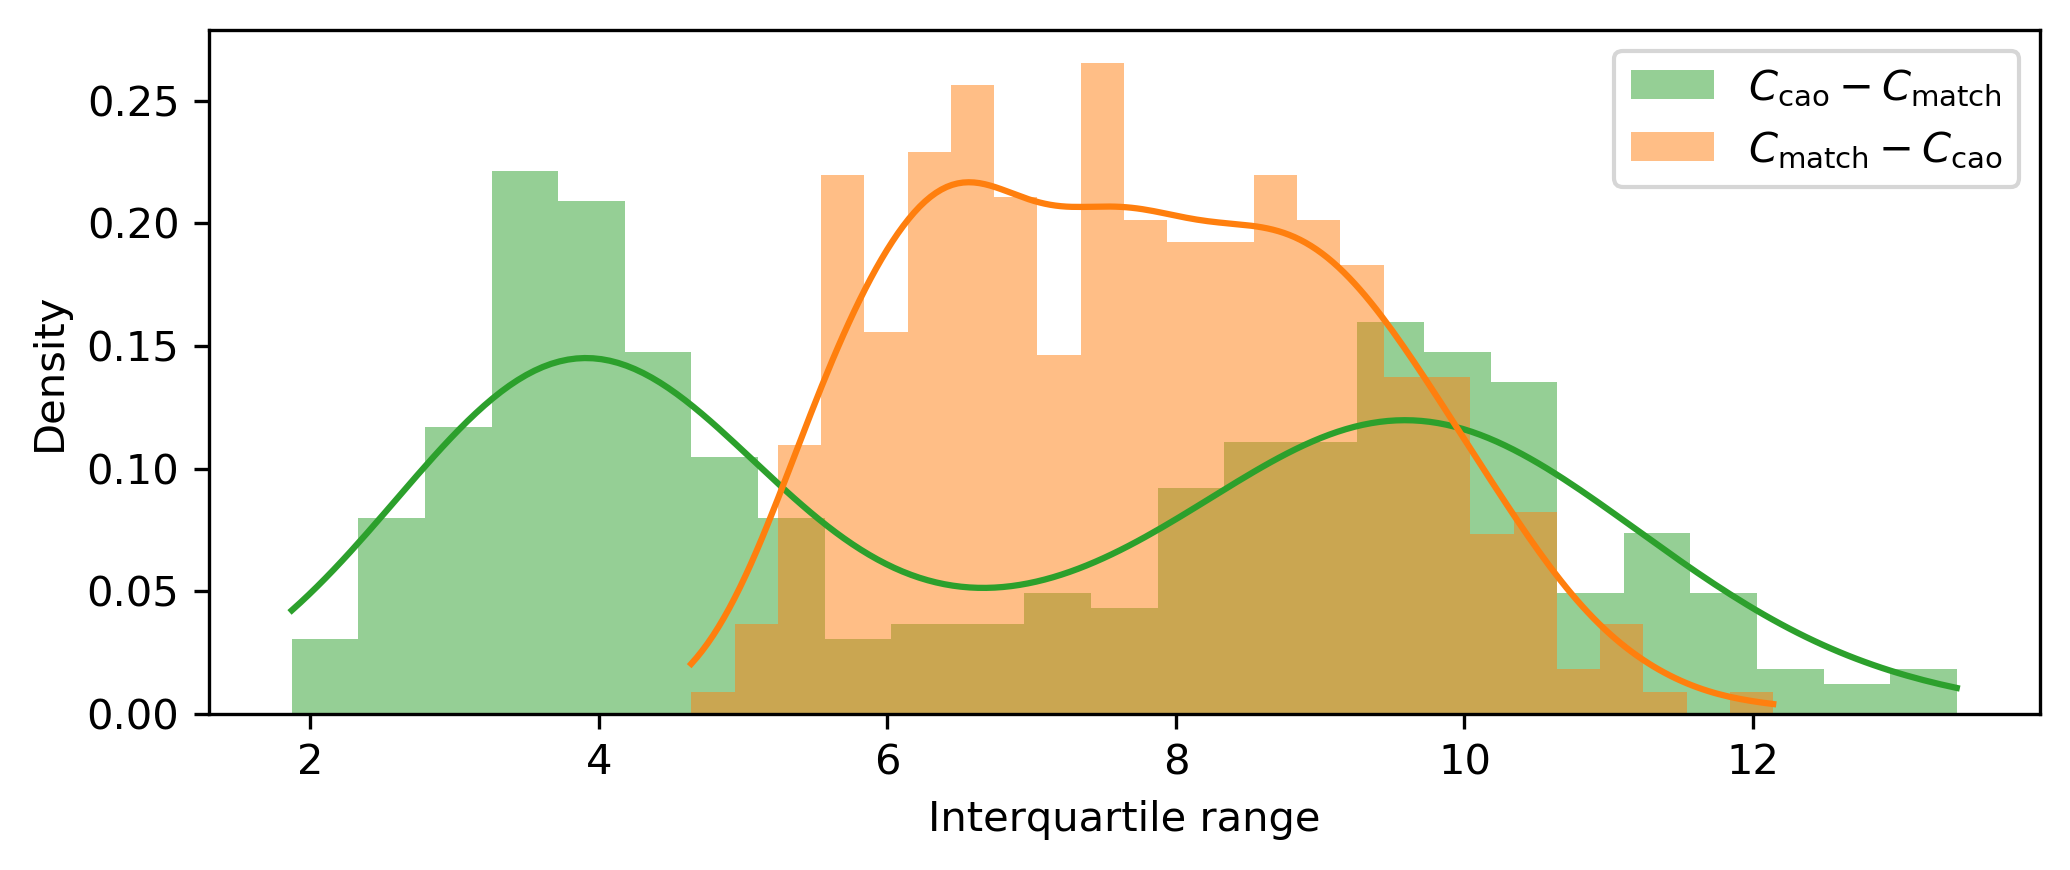

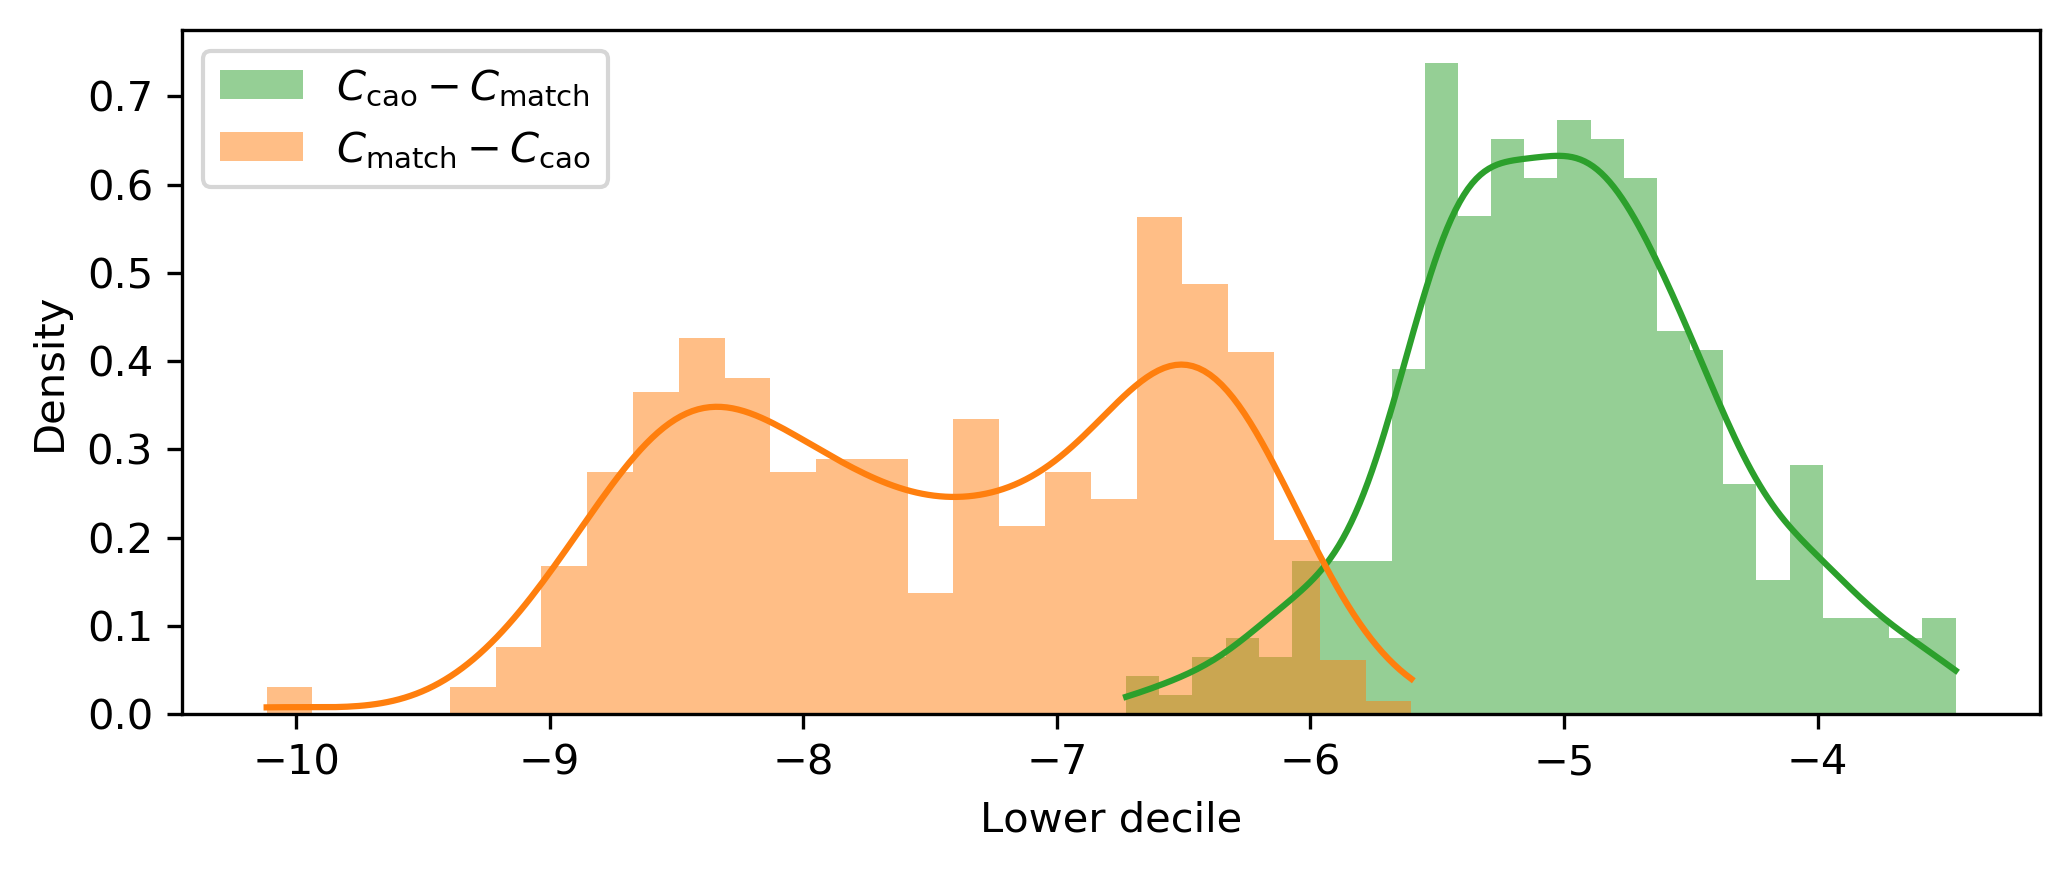

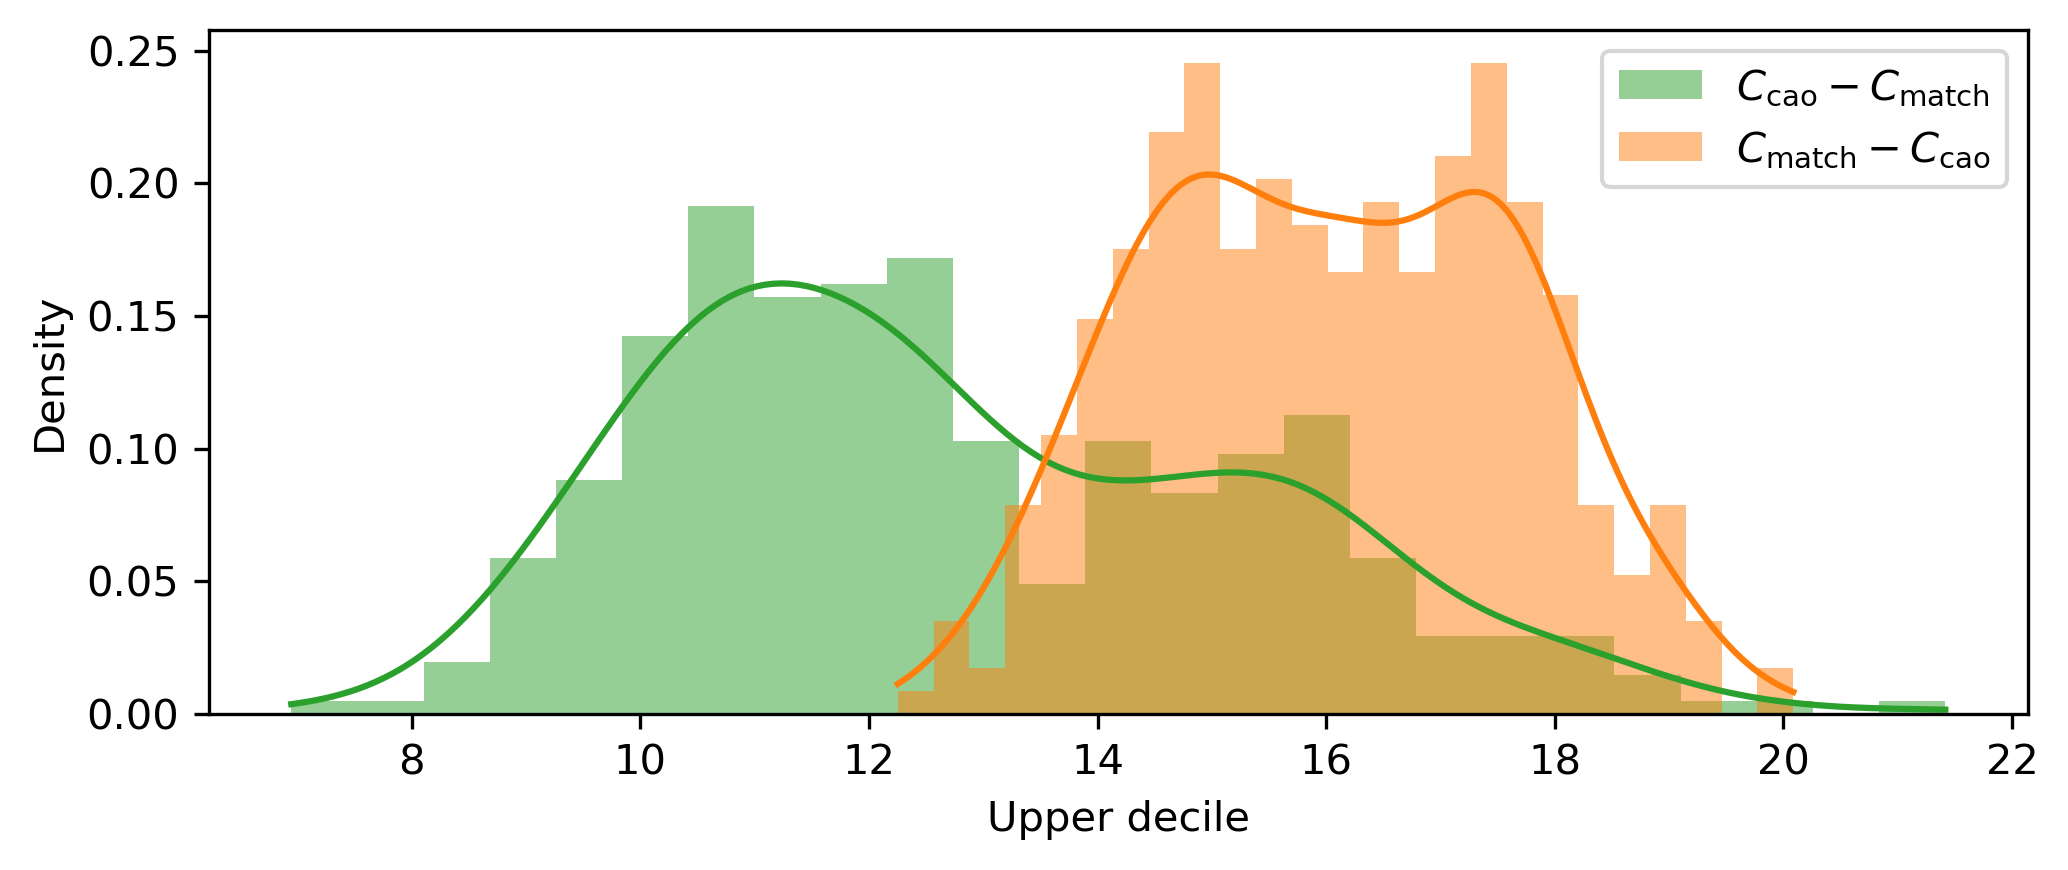

In [16]:
bins = 25
steps = 200

for stat, filename in zip(
    (
        "variance",
        "skewness",
        "kurtosis",
        "interquartile range",
        "lower decile",
        "upper decile",
    ),
    ("Fig10a", "Fig10b", "Fig10c", "Fig11a", "Fig11b", "Fig11c"),
):
    hist_with_dist_plot(stat, bins, steps, f"../img/{filename}.pdf")
